# Introduction

For this particular notebook, I will start use a very basic Multilayer Perceptron for the purposes of testing out how training, evalutation and testing will take place. As well as how the my predictions will be formated for submission.

In [1]:
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Loading

In [2]:
image_folder = "IMAGES_1024/IMAGES_1024/"

In [3]:
train = pd.read_csv("Train.csv")
print(train.shape)
train.head()

(1326, 5)


,Image_ID,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


In [4]:
# replace image_id with image_path
for i in range(train.shape[0]):
    image_path = os.path.join(image_folder, train["Image_ID"][i] + ".JPG")
    if os.path.exists(image_path):
        train.loc[i, "Image_ID"] = image_path

In [5]:
train.head()

,Image_ID,x,y,w,h
0,IMAGES_1024/IMAGES_1024/04FB1B33.JPG,0.481988,0.506076,0.174696,0.405671
1,IMAGES_1024/IMAGES_1024/B04E481E.JPG,0.617405,0.313368,0.177734,0.293113
2,IMAGES_1024/IMAGES_1024/32655645.JPG,0.490885,0.465856,0.165582,0.357350
3,IMAGES_1024/IMAGES_1024/44D4DA7C.JPG,0.472873,0.506076,0.237847,0.409722
4,IMAGES_1024/IMAGES_1024/4F36EF72.JPG,0.433811,0.574363,0.180773,0.397569


In [6]:
train.to_csv("Train_New.csv", index=False)

In [7]:
# create a class for creating a dataset with one image and 4 labels.
# this will also apply to our model sice this task is a multi-label
# image classification task. Our model thus should output 4 distinct outputs.
class TurtleDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, transform=None):
        
        self.csv_path = pd.read_csv(csv_path)
        self.transform = transform
        
        # initialize arrays for storing image paths and labels
        self.data = []
        self.x = []
        self.y = []
        self.w = []
        self.h = []
        
        # read from csv file
        for i in range(self.csv_path.shape[0]):
                self.data.append(self.csv_path.loc[i, "Image_ID"])
                self.x.append(self.csv_path.loc[i, "x"] * 700)
                self.y.append(self.csv_path.loc[i, "y"] * 700)
                self.w.append(self.csv_path.loc[i, "w"] * 700)
                self.h.append(self.csv_path.loc[i, "h"] * 700)
                
    def  __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        data_dict = {
            "image": image,
            "label": {
                "x": self.x[idx],
                "y": self.y[idx],
                "w": self.w[idx],
                "h": self.h[idx]
            }
        }
        
        return data_dict

**NOTE**

You'll notice that we've mutipkied every x y w h  coordinate with 700, reason bekow:

x, y, w, h coordinates are very small numbers that will be zeroed if I convert them to type Long, which is what PyTorch is complaining about. 
Possible solution is scaling them up according to width and length of the new images and using the scaled values as coordinates.
x, y, w, h = 700 * array[x, y, w, h]
Where (32, 3, 700, 700) is the new shape of a single batch of images. This should work because all coordinates will be > 1, and conversion to type Long only leads to less precision and not zeroing.

Building custom Datasets

https://www.learnopencv.com/multi-label-image-classification-with-pytorch/

https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f

# 

## Preprocessing and Splitting 

In [8]:
transform = transforms.Compose([
    transforms.Resize((700, 700)),
    transforms.ToTensor()
])

In [9]:
data = TurtleDataset("Train_New.csv", transform=transform)

In [10]:
# data splits
trainsize = int(len(data) * 0.7)
validationsize = int((len(data) - trainsize) / 2)
testsize = validationsize

In [11]:
traindata, remdata = torch.utils.data.random_split(data, [trainsize, len(data) - trainsize])
validationdata, testdata = torch.utils.data.random_split(remdata, [validationsize, testsize])

In [12]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=32)
validationloader = torch.utils.data.DataLoader(validationdata, batch_size=32)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32)

#  

## Visualization

Visualizing both images solely and images with their bouding boxes.

In [37]:
def draw_Boundbox(image, points, color, alpha):
    # get the actual image size for scaling of the label points
#     image_h, image_w = image.shape[1], image.shape[2]
#     print(points["x"]*image_w, points["x"])
#     return Rectangle((points["x"]*image_w, points["y"]*image_h), 
#                      points["w"]*image_w, points["h"]*image_h, ec=color,
#                      fc=color, alpha=alpha)
#     print(points["x"], points["x"])
    return Rectangle((points["x"], points["y"]), 
                     points["w"], points["h"], ec=color,
                     fc=color, alpha=alpha)

torch.Size([3, 700, 700]) {'x': 281.0329861111111, 'y': 467.47685185185185, 'w': 205.6857638888889, 'h': 232.52314814814815}


([], [])

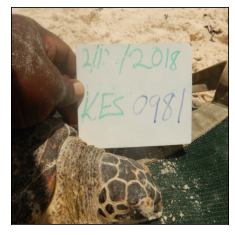

In [38]:
sample = traindata[1]

print(sample["image"].shape, sample["label"])

plt.imshow(np.transpose(sample["image"].numpy(), (1, 2, 0)))
plt.xticks([])
plt.yticks([])

([], [])

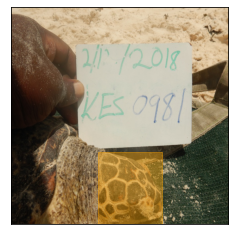

In [39]:
bound_box = draw_Boundbox(sample["image"], sample["label"], 'orange', .4)
plt.imshow(np.transpose(sample["image"].numpy(), (1, 2, 0)))
ax = plt.gca()
ax.autoscale(enable=False)
ax.add_patch(bound_box)
plt.xticks([])
plt.yticks([])

#  

## Model Design 

Model architecture and hyper parameters.

In [16]:
class MultiLabelNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base = models.mobilenet_v2().features
        last_channel = models.mobilenet_v2().last_channel
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.x = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=700)
        )
        
        self.y = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=700)
        )
        
        self.w = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=700)
        )
        
        self.h = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=700)
        )
        
    def forward(self, x):
        x = self.base(x)
        x = self.pool(x)
        
        x = torch.flatten(x, start_dim=1)
        
        return {
            "x": self.x(x),
            "y": self.y(x),
            "w": self.w(x),
            "h": self.h(x)
        }

In [17]:
model = MultiLabelNetwork()
model

MultiLabelNetwork(
  (base): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=

In [18]:
def criterion(output, labels):
    xloss = F.cross_entropy(output["x"], labels["x"].long())
    yloss = F.cross_entropy(output["y"], labels["y"].long())
    wloss = F.cross_entropy(output["w"], labels["w"].long())
    hloss = F.cross_entropy(output["h"], labels["h"].long())
    
    loss = xloss + yloss + wloss + hloss
    
    return loss, {"x": xloss, "y": yloss, "w": wloss, 
                 "h": hloss}

In [19]:
optimizer = torch.optim.Adam(model.parameters())

# 

# Pre-model testing 

In [20]:
data = next(iter(trainloader))
images, labels = data["image"], data["label"]

In [21]:
output = model(images)

In [22]:
output

{'x': tensor([[ 0.1378, -0.0078, -0.1713,  ...,  0.1885, -0.2519, -0.0606],
         [ 0.0043, -0.0630, -0.0831,  ...,  0.2464, -0.5441, -0.3184],
         [ 0.0562, -0.0622, -0.2154,  ...,  0.1841, -0.3307, -0.1960],
         ...,
         [ 0.2098, -0.1125, -0.2370,  ...,  0.1314, -0.3651, -0.2680],
         [ 0.0923, -0.0986, -0.1826,  ..., -0.0053, -0.2795,  0.1628],
         [-0.3864, -0.2943, -0.2055,  ...,  0.3414, -0.5365,  0.0419]],
        grad_fn=<AddmmBackward>),
 'y': tensor([[-0.2090,  0.3478,  0.3581,  ...,  0.3740,  0.1298, -0.0755],
         [-0.0801,  0.2328,  0.3553,  ...,  0.2112, -0.0325, -0.0662],
         [-0.1387,  0.0725,  0.0517,  ...,  0.2431, -0.0484,  0.0337],
         ...,
         [-0.4618,  0.1743,  0.3921,  ...,  0.4466,  0.2597,  0.2698],
         [-0.2652,  0.1077,  0.3067,  ...,  0.2929,  0.1165,  0.1696],
         [-0.0674,  0.0052,  0.2291,  ...,  0.2118,  0.0762,  0.2813]],
        grad_fn=<AddmmBackward>),
 'w': tensor([[-0.2762, -0.1898, -0.3317

In [23]:
labels

{'x': tensor([285.8941, 281.0330, 328.8845, 337.9991, 301.6927, 191.8620, 136.1111,
         273.5894, 293.1858, 298.1988, 366.8620, 337.9842, 412.1311, 159.3533,
         380.5339, 411.0750, 284.3750, 282.5264, 351.8229, 282.8559, 159.2500,
         292.5781,  89.4590, 308.3767, 229.1978, 264.9306, 280.5773, 320.5295,
         311.1111, 326.4540, 279.0582, 375.8247], dtype=torch.float64),
 'y': tensor([328.5301, 467.4769, 281.1343, 309.8958, 370.2546, 447.0197, 345.6019,
         241.4352, 284.5775, 430.8160, 239.0046, 277.2887, 297.5405, 202.3438,
         482.6678, 129.7333, 320.8333, 418.6033, 227.2569, 160.2141, 421.6333,
         260.4745, 148.6629, 344.5312,   0.0000, 214.4290, 406.3079, 352.9707,
         255.2083, 245.2836, 427.9803, 391.7245], dtype=torch.float64),
 'w': tensor([128.9714, 205.6858, 335.2648, 155.4036, 171.0503, 153.8845, 207.4653,
         221.9401, 204.6224, 120.3125, 234.0929, 178.6972, 275.5642, 302.1484,
         219.5095, 212.1000,  95.5106, 138.0282, 24

In [24]:
output['x'][0].shape, labels['x'][0]

(torch.Size([700]), tensor(285.8941, dtype=torch.float64))

In [25]:
loss, coordinate_losses = criterion(output, labels)

In [26]:
loss

tensor(26.4327, grad_fn=<AddBackward0>)

In [27]:
coordinate_losses

{'x': tensor(6.6524, grad_fn=<NllLossBackward>),
 'y': tensor(6.5334, grad_fn=<NllLossBackward>),
 'w': tensor(6.6059, grad_fn=<NllLossBackward>),
 'h': tensor(6.6410, grad_fn=<NllLossBackward>)}

In [28]:
data = next(iter(testloader))
images, labels = data["image"], data["label"]

In [53]:
image = images[7]

([], [])

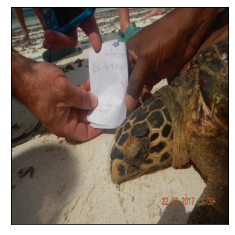

In [54]:
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.xticks([])
plt.yticks([])

In [55]:
image_ = image.unsqueeze(0)
image_.shape

torch.Size([1, 3, 700, 700])

In [56]:
output = model(image_)

In [57]:
_, pred_x = torch.max(output['x'], 1)
_, pred_y = torch.max(output['y'], 1)
_, pred_w = torch.max(output['w'], 1)
_, pred_h = torch.max(output['h'], 1)

In [58]:
points = {'x': pred_x.item(), 'y': pred_y.item(), 'w': pred_w.item(), 'h': pred_h.item()}
points

{'x': 534, 'y': 475, 'w': 98, 'h': 654}

In [59]:
label = {'x': labels['x'][0].item(), 'y': labels['y'][0].item(), 'w': labels['w'][0].item(), 'h': labels['h'][0].item()}
label

{'x': 274.1970486111111,
 'y': 307.8703703703704,
 'w': 181.2282986111111,
 'h': 392.1296296296297}

([], [])

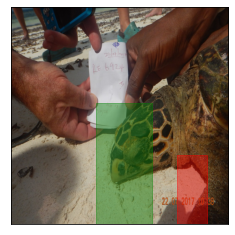

In [61]:
bound_box_real = draw_Boundbox(image, label, 'green', .4)
bound_box_pred = draw_Boundbox(image, points, 'red', .4)
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
ax = plt.gca()
ax.autoscale(enable=False)
ax.add_patch(bound_box_real)
ax.add_patch(bound_box_pred)
plt.xticks([])
plt.yticks([])

# 

## Training and Evaluation 

In [12]:
epochs = 10
trainlosses = []
validationlosses =[]

In [41]:
for epoch in range(epochs):
    
    running_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for batch_idx, data in enumerate(trainloader):
        images, labels = data["image"], data["label"]
        
        optimizer.zero_grad()
        
        output = model(images)
        loss, coordinate_losses = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        trainlosses.append(running_loss/len(trainloader))
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch}, Train Loss {running_loss}")
        
    model.eval()
    for batch_idx, data in enumerate(validationloader):
        images, labels = data["image"], data["label"]
        
        output = model(images)
        loss, coordinate_losses = criterion(output, torch.LongTensor(label))
                
        valid_loss += loss.item()
        validationlosses.append(valid_loss/len(validationloader))
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch}, Validation Loss {valid_loss}")

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 564480000 bytes. Buy new RAM!

In [43]:
labels['x'].dtype

torch.int64

In [44]:
labels['x']

tensor([389, 268, 337, 263, 350, 331, 225, 333, 186, 362, 221, 221, 339, 234,
        240, 302, 282, 349, 132, 247, 255, 343, 113, 219, 277, 177, 247, 300,
        238, 278, 279, 199])

In [46]:
output['x'].dtype

torch.float32

In [47]:
output['x']

tensor([[0.2561],
        [0.4443],
        [0.5970],
        [0.2729],
        [0.4337],
        [0.4512],
        [0.7767],
        [0.6243],
        [0.7643],
        [0.3255],
        [0.4745],
        [0.4342],
        [0.3678],
        [0.6075],
        [0.3377],
        [0.3561],
        [0.3675],
        [0.5338],
        [0.4565],
        [0.4777],
        [0.5963],
        [0.8425],
        [0.6657],
        [0.4256],
        [0.4617],
        [0.3778],
        [0.3305],
        [0.8265],
        [1.0165],
        [0.3527],
        [0.3824],
        [0.3993]], grad_fn=<AddmmBackward>)

In [48]:
F.cross_entropy(output['x'], labels['x'].long())

IndexError: Target 389 is out of bounds.

In [24]:
criterion(output, labels)

RuntimeError: expected scalar type Long but found Double

## Metrics Analysis 

Visualize model accuracy in training against number of epochs.

Visualize model training and evaluation losses agains number of epochs.

## Testing 

Testing of the trained model using accuracy and also visualizing ground truths against predicted bounding box.

## Submission